In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

In [2]:
transform = transforms.Compose([
    transforms.Resize((32,32), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [14]:
batch_size = 64

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle = False)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
def plot_sample_images(train_loader, class_names, num_samples=5):
    sample_batch, sample_labels = next(iter(train_loader))
    plt.figure(figsize=(10, 10))

    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(sample_batch[i].squeeze().numpy(), cmap='gray')
        plt.title(f"{class_names[sample_labels[i]]}")
        plt.axis('off')
    plt.show()

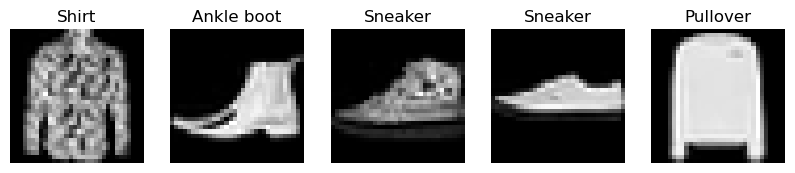

In [17]:
plot_sample_images(train_loader, train_dataset.classes)

In [18]:
class AutoencoderFC(nn.Module):
    def __init__(self):
        super(AutoencoderFC,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1*32*32, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,64),
            nn.BatchNorm1d(64),    
            nn.LeakyReLU(0.2),
            nn.Linear(64,16),
            nn.BatchNorm1d(16),    
            nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1*32*32),
            nn.Tanh()
        )

    def forward(self, x):
        # x = x.view(x.size(0),-1)
        x = nn.Flatten()(x)
        x = self.encoder(x)
        x = self.decoder(x)
        # x = x.view(x.size(0), 3, 32, 32)
        x = nn.Unflatten(1,(1,32,32))(x)
        return x

In [19]:
def square_mask(images, mask_size):

    batch_size, channels, height, width = images.size()
    mask = torch.zeros(batch_size, 1, height, width, dtype=torch.float32, device=images.device)
    
    max_top = height - mask_size - 1
    max_left = width - mask_size - 1

    top = np.random.randint(3, max_top, size=batch_size)
    left = np.random.randint(3, max_left, size=batch_size)

    for i in range(batch_size):
        mask[i, :, top[i]:top[i] + mask_size, left[i]:left[i] + mask_size] = 1

    return mask

In [20]:
def plot_masked_images(train_loader, mask_size, num_samples):
    sample_original, _ = next(iter(train_loader))
    sample_masked = sample_original.clone()
    mask = square_mask(sample_masked, mask_size)
    sample_masked[mask == 1] = 0
    fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(10, 10))

    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(sample_masked[i, 0], cmap='gray')
        ax.set_title('Masked')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

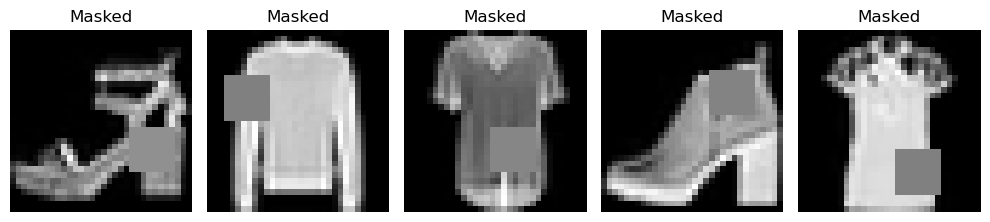

In [22]:
num_samples=5
mask_size=8
plot_masked_images(train_loader, mask_size, num_samples)

In [24]:
model = AutoencoderFC().to(device)
criterion = nn.MSELoss()
criterion_global = nn.MSELoss()
criterion_local = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

def train_model(model, train_loader, optimizer, criterion_global, criterion_local, num_epochs, mask_size, device):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss_global = 0.0
        running_loss_local = 0.0
        for images, _ in train_loader:
            images = images.to(device)

            mask = square_mask(images, mask_size)
            masked_images = images.clone()
            masked_images[mask == 1] = 0

            outputs = model(masked_images)

            loss_global = criterion_global(outputs, images)

            loss_local = criterion_local(outputs[mask == 1], images[mask == 1])

            optimizer.zero_grad()
            
            (loss_global + loss_local).backward()
            optimizer.step()

            running_loss_global += loss_global.item()
            running_loss_local += loss_local.item()

        epoch_loss_global = running_loss_global / len(train_loader)
        epoch_loss_local = running_loss_local / len(train_loader)
        train_losses.append((epoch_loss_global, epoch_loss_local))
        print(f'Training Epoch [{epoch+1}/{num_epochs}], Global Loss: {epoch_loss_global:.4f}, Local Loss: {epoch_loss_local:.4f}')

    return train_losses

In [25]:
train_losses = train_model(model, train_loader, optimizer, criterion_global, criterion_local, num_epochs, mask_size, device)

Training Epoch [1/20], Global Loss: 0.0969, Local Loss: 0.1316
Training Epoch [2/20], Global Loss: 0.0733, Local Loss: 0.1081
Training Epoch [3/20], Global Loss: 0.0680, Local Loss: 0.1011
Training Epoch [4/20], Global Loss: 0.0649, Local Loss: 0.0976
Training Epoch [5/20], Global Loss: 0.0626, Local Loss: 0.0949
Training Epoch [6/20], Global Loss: 0.0607, Local Loss: 0.0920
Training Epoch [7/20], Global Loss: 0.0594, Local Loss: 0.0911
Training Epoch [8/20], Global Loss: 0.0581, Local Loss: 0.0892
Training Epoch [9/20], Global Loss: 0.0571, Local Loss: 0.0874
Training Epoch [10/20], Global Loss: 0.0563, Local Loss: 0.0869
Training Epoch [11/20], Global Loss: 0.0555, Local Loss: 0.0856
Training Epoch [12/20], Global Loss: 0.0546, Local Loss: 0.0846
Training Epoch [13/20], Global Loss: 0.0541, Local Loss: 0.0842
Training Epoch [14/20], Global Loss: 0.0536, Local Loss: 0.0839
Training Epoch [15/20], Global Loss: 0.0529, Local Loss: 0.0828
Training Epoch [16/20], Global Loss: 0.0523, Loca

In [26]:
def plot_losses(train_losses):
    num_epochs = len(train_losses)
    global_losses = [loss[0] for loss in train_losses]
    local_losses = [loss[1] for loss in train_losses]

    plt.plot(range(1, num_epochs + 1), global_losses, label='Global Loss')
    plt.plot(range(1, num_epochs + 1), local_losses, label='Local Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.show()

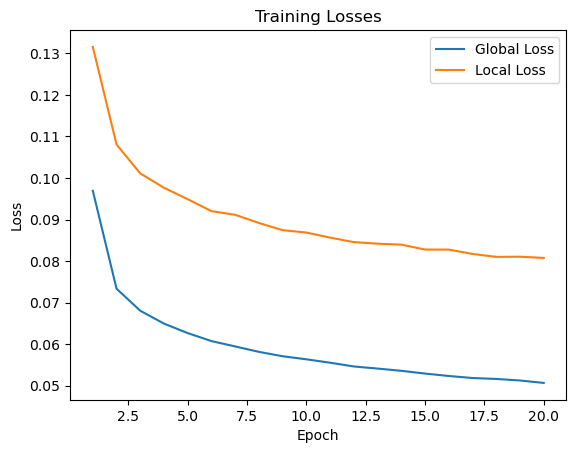

In [27]:
plot_losses(train_losses)

In [33]:
def valid_model(model, valid_dataloader, criterion, device):
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, _ in valid_dataloader:
            images = images.to(device)
            noisy_images = images + 0.1 * torch.randn_like(images)
            outputs = model(noisy_images)
            valid_loss += criterion(outputs, images).item()

    average_valid_loss = valid_loss / len(valid_dataloader)
    print(f'Average Test Loss: {average_valid_loss:.4f}')
    return average_valid_loss

In [34]:
valid_loss = valid_model(model, valid_dataloader, criterion, device)

Average Test Loss: 0.0468


In [35]:
def visualize_inpainting(model, dataloader, mask_size):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(dataloader))  # Taking one batch from the dataloader
        masked_images = images.clone()
        mask = square_mask(images, mask_size)
        masked_images[mask == 1] = 0
        inpainted_images = model(masked_images)

        # Extract masked region from original and reconstructed images
        reconstructed_masked_region = inpainted_images.clone()
        reconstructed_masked_region[mask == 0] = 0

    images = (images + 1) / 2  # Denormalize images
    reconstructed_masked_region = (reconstructed_masked_region + 1) / 2

    fig, axs = plt.subplots(3, 5, figsize=(15, 9))

    for i in range(5):
        axs[0, i].imshow(images[i].squeeze(), cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title('Original Image')

        axs[1, i].imshow(reconstructed_masked_region[i].squeeze(), cmap='gray')
        axs[1, i].axis('off')
        axs[1, i].set_title('Reconstructed Masked Region')

        # Perform full reconstruction
        full_reconstructed_image = images.clone()
        full_reconstructed_image[i, 0, mask[i, 0] == 1] = reconstructed_masked_region[i, 0, mask[i, 0] == 1]

        axs[2, i].imshow(full_reconstructed_image[i].squeeze(), cmap='gray')
        axs[2, i].axis('off')
        axs[2, i].set_title('Full Reconstructed Image')

    plt.tight_layout()
    plt.show()

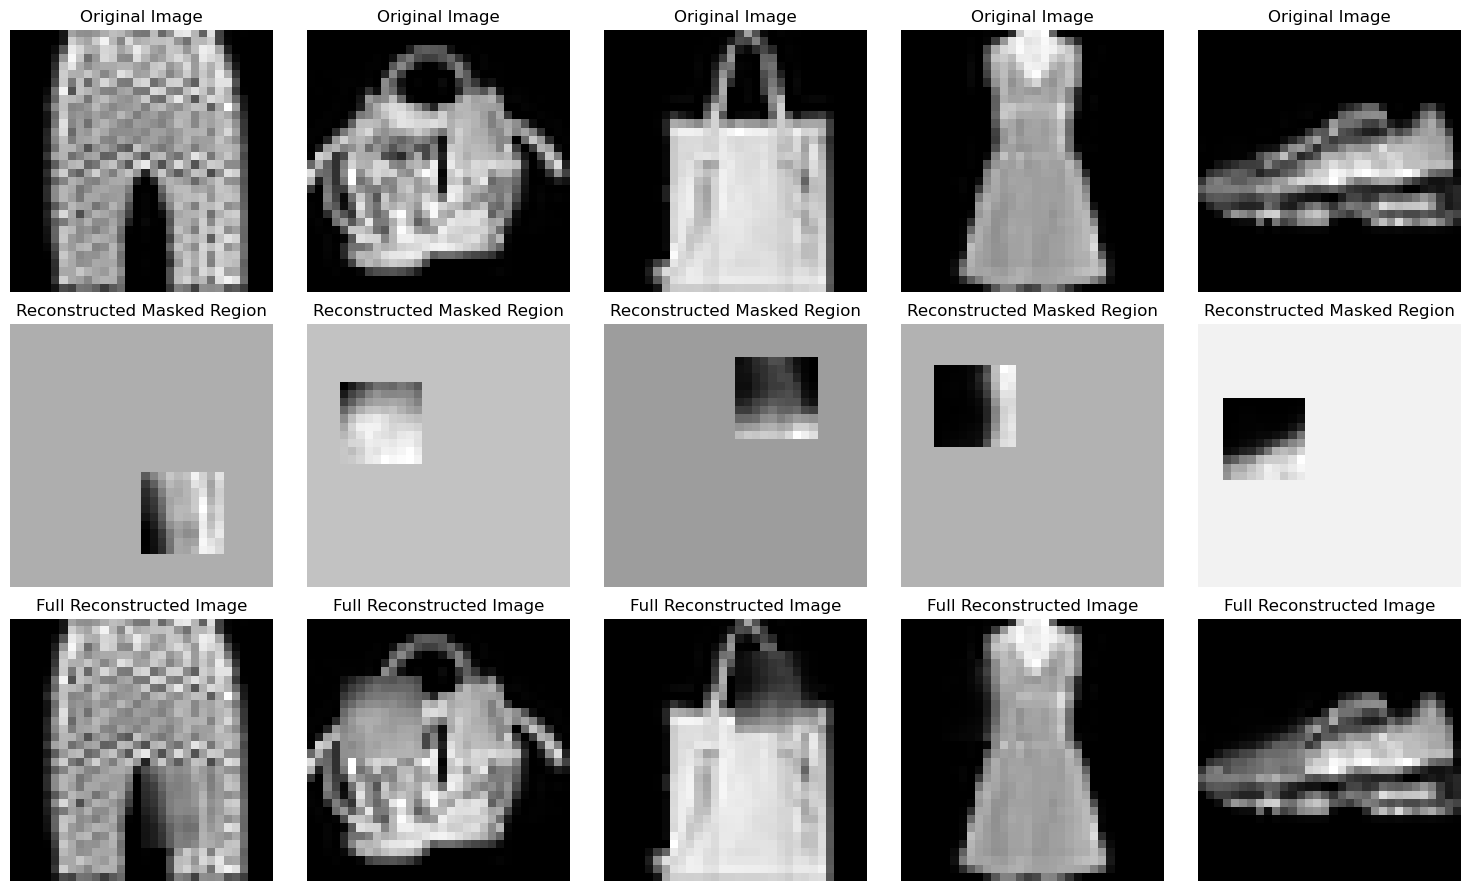

In [36]:
visualize_inpainting(model, train_loader, mask_size=10)